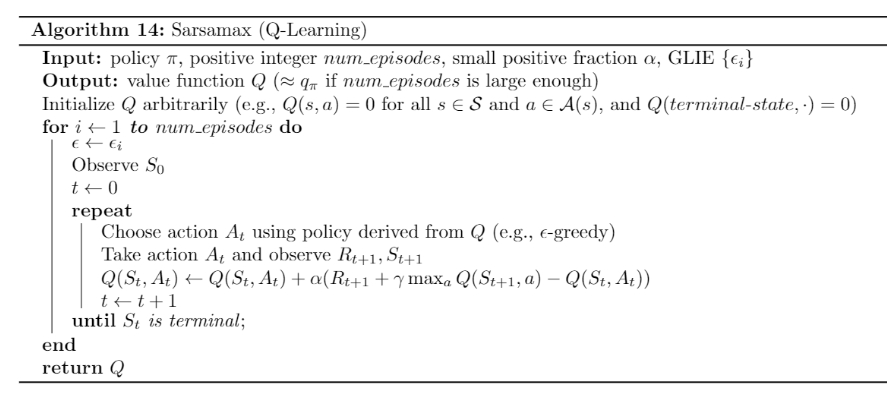

In [ ]:
import gym
import tqdm
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
train_env = gym.make("CartPole-v1")
test_env = gym.make("CartPole-v1")
train_env.observation_space.shape[0], train_env.action_space.n

(4, 2)

In [ ]:
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
def init_parameters(p):
    if type(p) == nn.Linear:
        nn.init.kaiming_normal_(p.weight)
        p.bias.data.fill_(0)

In [ ]:
def train(env, policy, gamma, epsilon, device):
    policy.train()
    ep_reward = 0
    state = env.reset()
    state = torch.FloatTensor(state).unsqueeze(0).to(device)
    done = False

    while not done:
        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            q_pred = policy(state)
            action = torch.argmax(q_pred).item()

        next_state, reward, done, _ = env.step(action)
        next_state = torch.FloatTensor(next_state).unsqueeze(0).to(device)
        
        loss = update_policy(policy, state, action, reward, next_state, done, gamma, opt)
        state = next_state
        ep_reward += reward

    return loss, ep_reward

In [ ]:
def update_policy(policy, state, action, reward, next_state, done, gamma, opt):
    q_pred = policy(state)
    q_val = q_pred[:, action]

    with torch.no_grad():
        q_next_pred = policy(next_state)
        q_next_val = q_next_pred.max(1).values
        target = reward + gamma * q_next_val

    loss = F.smooth_l1_loss(target.detach(), q_val)
    opt.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(policy.parameters(), 0.5)
    opt.step()

    return loss.item()

In [ ]:
def evaluate(env, policy, device):
    policy.eval()
    ep_reward = 0
    state = env.reset()
    done = False

    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            q_pred = policy(state)
            action = torch.argmax(q_pred).item()

        state, reward, done, _ = env.step(action)
        ep_reward += reward

    return ep_reward

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else  "cpu")
episodes = 501
gamma = 0.8
epsilon = 1.0
epsilon_decay = 0.995
min_epsilon = 0.01
input_dim = train_env.observation_space.shape[0]
hidden_dim = 32
output_dim = train_env.action_space.n
lr = 1e-6

In [ ]:
device

device(type='cuda')

In [ ]:
policy = Net(input_dim, hidden_dim, output_dim).to(device)
opt = torch.optim.RMSprop(policy.parameters(), lr)
policy.apply(init_parameters)
policy

Net(
  (fc1): Linear(in_features=4, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
  (relu): ReLU()
)

In [ ]:
losses = []
train_rewards = []
test_rewards = []

In [ ]:
for ep in range(episodes):
    loss, train_reward = train(train_env, policy, gamma, epsilon, device)
    test_reward = evaluate(test_env, policy, device)
    epsilon = max(epsilon * epsilon_decay, min_epsilon)

    losses.append(loss)
    train_rewards.append(train_reward)
    test_rewards.append(test_reward)
    
    if ep % 50 == 0:
        l = sum(losses) / len(losses)
        trr = sum(train_rewards) / len(train_rewards)
        ter = sum(test_rewards) / len(test_rewards)
        print(f"episode: {ep} | loss: {l:.4f} | train_reward: {trr} | test_reward: {ter}")

        losses = []
        train_rewards = []
        test_rewards = []

episode: 0 | loss: 2.1776 | train_reward: 22.0 | test_reward: 166.0
episode: 50 | loss: 1.2023 | train_reward: 30.18 | test_reward: 265.18
episode: 100 | loss: 0.8949 | train_reward: 37.98 | test_reward: 264.34
episode: 150 | loss: 0.7044 | train_reward: 65.68 | test_reward: 242.76
episode: 200 | loss: 0.6313 | train_reward: 76.52 | test_reward: 229.06
episode: 250 | loss: 0.5084 | train_reward: 132.0 | test_reward: 231.34
episode: 300 | loss: 0.3190 | train_reward: 131.28 | test_reward: 258.28
episode: 350 | loss: 0.3826 | train_reward: 140.54 | test_reward: 230.6
episode: 400 | loss: 0.3971 | train_reward: 151.6 | test_reward: 249.82
episode: 450 | loss: 0.3641 | train_reward: 167.62 | test_reward: 252.06
episode: 500 | loss: 0.3724 | train_reward: 184.38 | test_reward: 217.94
